Dùng GAN và conditional-GAN sinh ảnh trong dữ liệu fashion-MNIST

GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Chuẩn bị dữ liệu Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
batch_size = 64
data_loader = DataLoader(datasets.FashionMNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 14272217.15it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 227529.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4313980.54it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20427887.41it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Xây dựng mô hình Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

# Xây dựng mô hình Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
# Thiết lập hyperparameters
z_dim = 100  # Kích thước của vector ngẫu nhiên đầu vào cho Generator
img_dim = 784  # Kích thước ảnh Fashion-MNIST (28x28)

# Khởi tạo mô hình Generator và Discriminator
G = Generator(z_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)


In [ ]:
# Thiết lập optimizer
lr = 0.0002
G_opt = optim.Adam(G.parameters(), lr=lr)
D_opt = optim.Adam(D.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

In [ ]:
# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    for batch in data_loader:
        batch_size = batch[0].size(0)
        real_data = batch[0].view(batch_size, -1)
        fake_data = G(torch.rand(batch_size, z_dim))

        # Đối chiếu Discriminator trên dữ liệu thật và giả
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Tính toán loss của Discriminator
        D_real_loss = criterion(D(real_data), real_labels)
        D_fake_loss = criterion(D(fake_data), fake_labels)
        D_loss = D_real_loss + D_fake_loss

        # Backpropagation và cập nhật Discriminator
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Sinh dữ liệu giả mới và tính toán loss của Generator
        fake_data = G(torch.rand(batch_size, z_dim))
        G_loss = criterion(D(fake_data), real_labels)

        # Backpropagation và cập nhật Generator
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

    print(f"Epoch [{epoch+1}/{n_epochs}], D Loss: {D_loss.item()}, G Loss: {G_loss.item()}")

Epoch [1/100], D Loss: 0.00020315639267209917, G Loss: 9.692399024963379
Epoch [2/100], D Loss: 1.595709181856364e-05, G Loss: 11.76928424835205
Epoch [3/100], D Loss: 0.006686431355774403, G Loss: 8.02362060546875
Epoch [4/100], D Loss: 1.4901162970204496e-08, G Loss: 47.97290802001953
Epoch [5/100], D Loss: 3.007048853633409e-18, G Loss: 40.36231994628906
Epoch [6/100], D Loss: 3.955677778082697e-18, G Loss: 40.08208465576172
Epoch [7/100], D Loss: 7.450580596923828e-09, G Loss: 39.63492202758789
Epoch [8/100], D Loss: 6.490578141925432e-18, G Loss: 39.5722770690918
Epoch [9/100], D Loss: 6.837364101161245e-18, G Loss: 39.52334976196289
Epoch [10/100], D Loss: 1.4901164746561335e-08, G Loss: 39.47271728515625
Epoch [11/100], D Loss: 7.63916846688237e-18, G Loss: 39.413028717041016
Epoch [12/100], D Loss: 9.080377655842699e-18, G Loss: 39.22108840942383
Epoch [13/100], D Loss: 1.4345869464123514e-17, G Loss: 38.78298568725586
Epoch [14/100], D Loss: 1.5921491366720646e-17, G Loss: 38.

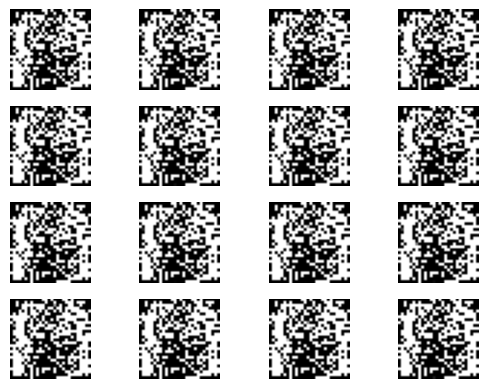

In [6]:
# Sử dụng Generator để sinh ảnh mới
num_samples = 16
test_noise = torch.rand(num_samples, z_dim)
generated_samples = G(test_noise)

# Hiển thị các ảnh được sinh ra
fig, axes = plt.subplots(4, 4)
for i, ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.imshow(generated_samples[i].view(28, 28).detach().numpy(), cmap='gray')
plt.show()

cGAN (conditional GAN)

In [7]:
img_size = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 50  # Train epochs
learning_rate = 1e-4
class_num =10

In [8]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):

        # Reshape z
        z = z.view(-1, self.z_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([z, c], 1)

        # Generator out
        out = self.model(x)

        return out.view(-1, self.img_size, self.img_size)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):

        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([x, c], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num=10).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num=10).to(device)

In [11]:
# Loss function
criterion = nn.BCELoss()
#Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [12]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data


In [13]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

Starting epoch 1...
g_loss: 4.212380409240723, d_loss: 0.2831462621688843


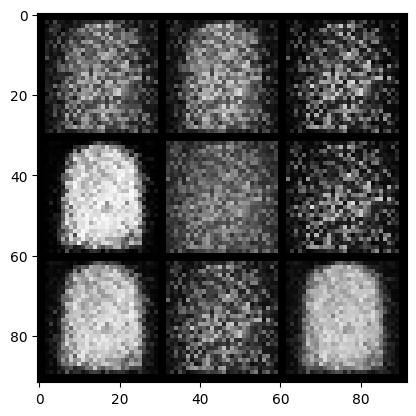

Starting epoch 2...
g_loss: 4.54508113861084, d_loss: 0.18107081949710846


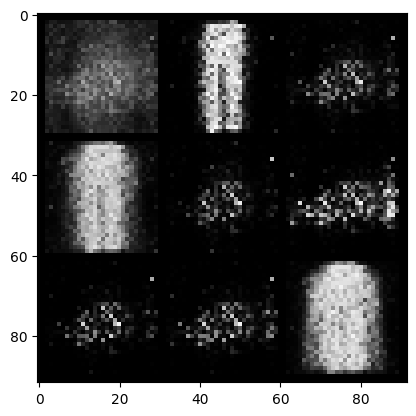

Starting epoch 3...
g_loss: 3.8911547660827637, d_loss: 0.5838066339492798


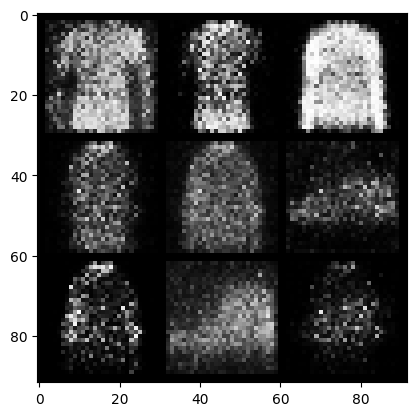

Starting epoch 4...
g_loss: 3.0464320182800293, d_loss: 1.0870115756988525


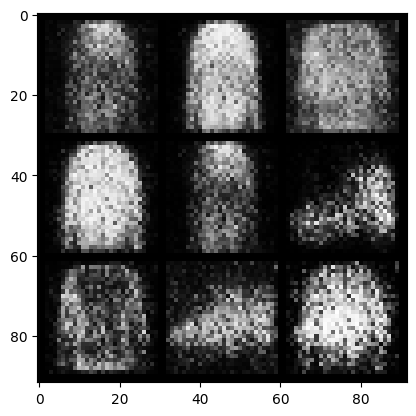

Starting epoch 5...
g_loss: 2.5073728561401367, d_loss: 0.7059392333030701


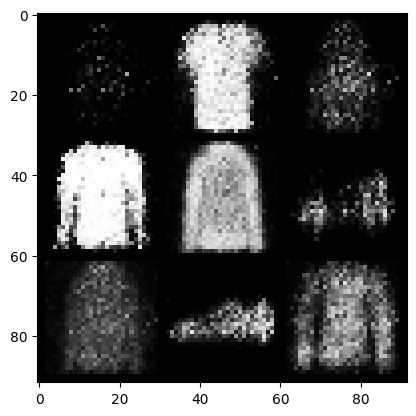

Starting epoch 6...
g_loss: 2.6344358921051025, d_loss: 0.7472419738769531


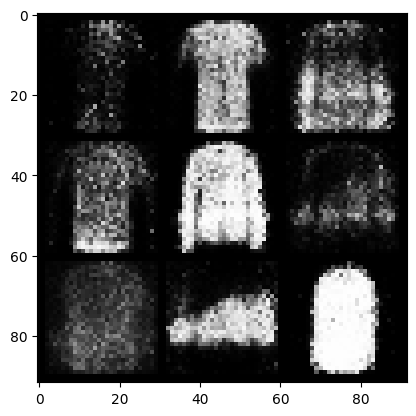

Starting epoch 7...
g_loss: 2.1147141456604004, d_loss: 0.8775027394294739


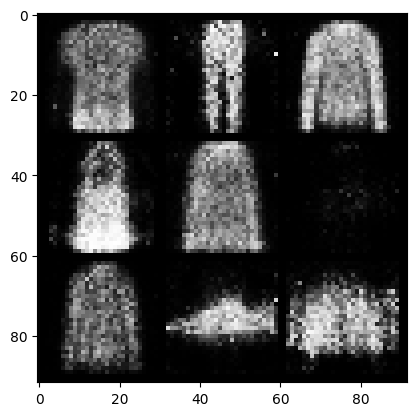

Starting epoch 8...
g_loss: 1.7194976806640625, d_loss: 0.9189353585243225


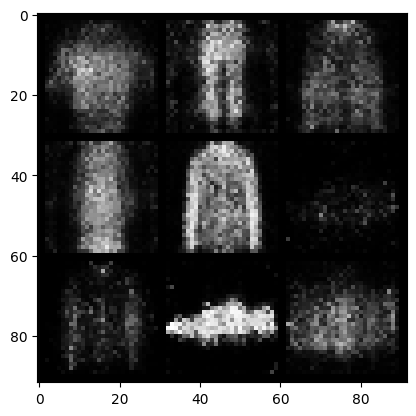

Starting epoch 9...
g_loss: 2.2322487831115723, d_loss: 0.6583501100540161


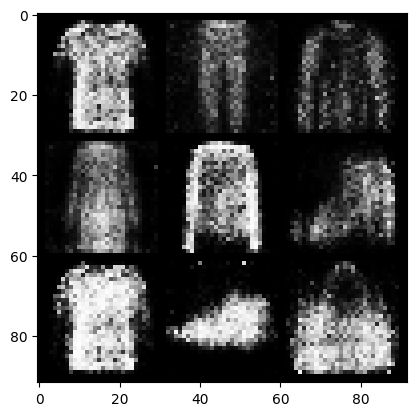

Starting epoch 10...
g_loss: 1.8621635437011719, d_loss: 0.8315507769584656


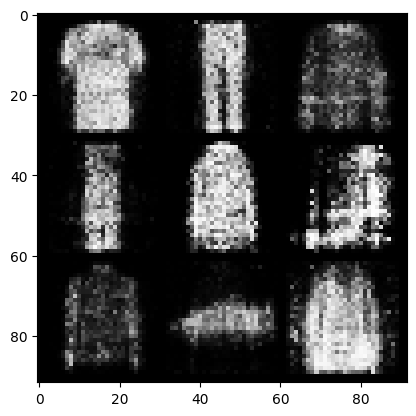

Starting epoch 11...
g_loss: 1.6918753385543823, d_loss: 0.6124239563941956


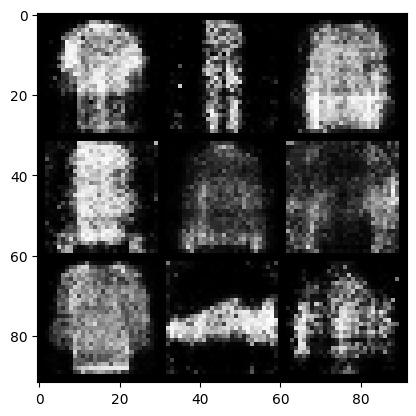

Starting epoch 12...
g_loss: 1.964598536491394, d_loss: 0.6123761534690857


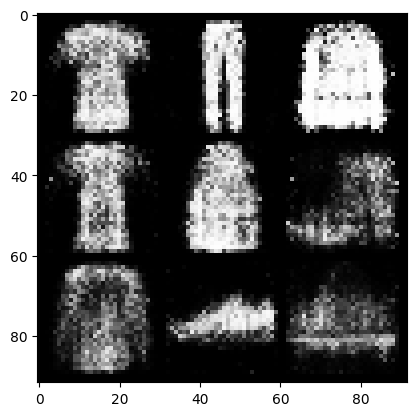

Starting epoch 13...
g_loss: 1.79876708984375, d_loss: 0.6584911942481995


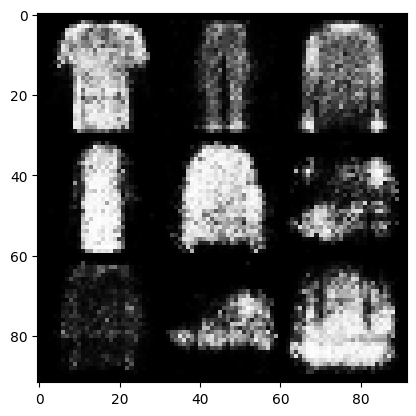

Starting epoch 14...
g_loss: 1.5826201438903809, d_loss: 1.063501238822937


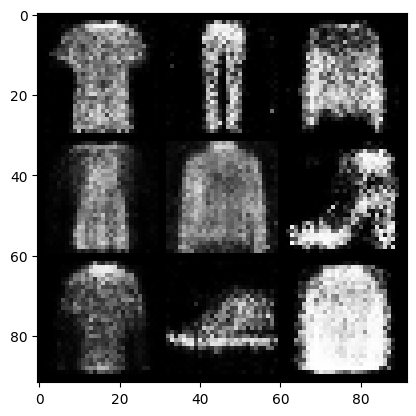

Starting epoch 15...
g_loss: 1.5611279010772705, d_loss: 0.6446119546890259


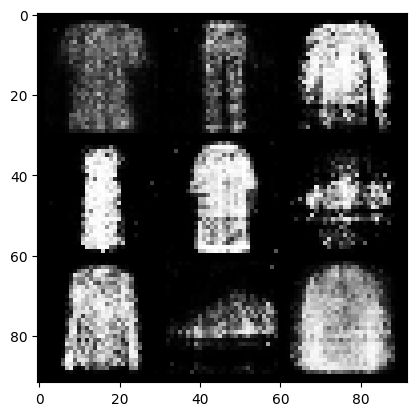

Starting epoch 16...
g_loss: 1.695886492729187, d_loss: 1.039212703704834


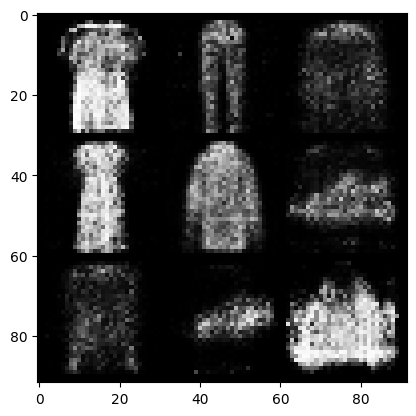

Starting epoch 17...
g_loss: 1.373962163925171, d_loss: 1.0658388137817383


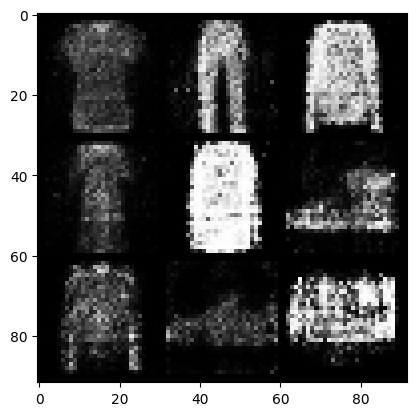

Starting epoch 18...
g_loss: 1.212315559387207, d_loss: 0.871868371963501


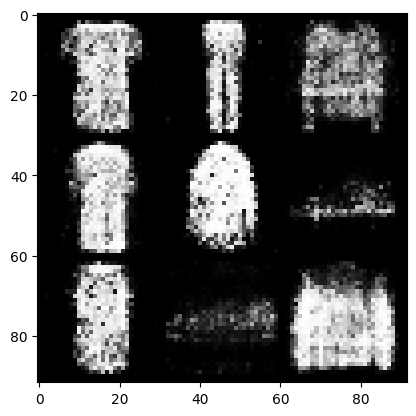

Starting epoch 19...
g_loss: 1.4235683679580688, d_loss: 1.0907007455825806


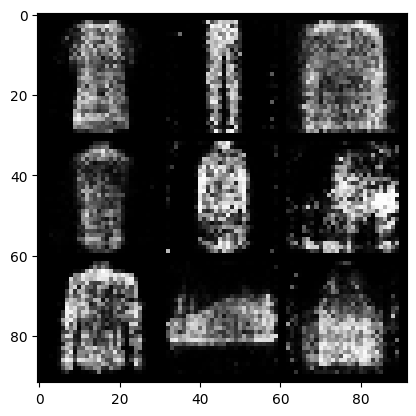

Starting epoch 20...
g_loss: 1.4331114292144775, d_loss: 0.8500836491584778


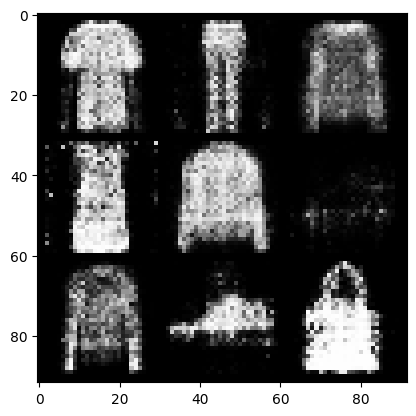

Starting epoch 21...
g_loss: 1.232700228691101, d_loss: 1.1762244701385498


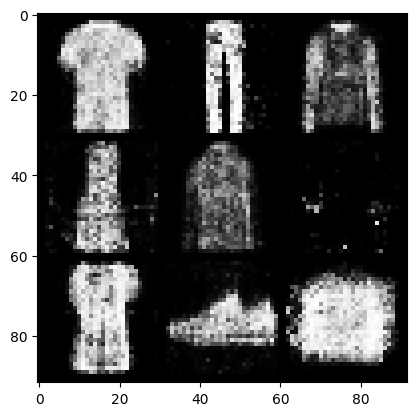

Starting epoch 22...
g_loss: 1.4524017572402954, d_loss: 0.8832451105117798


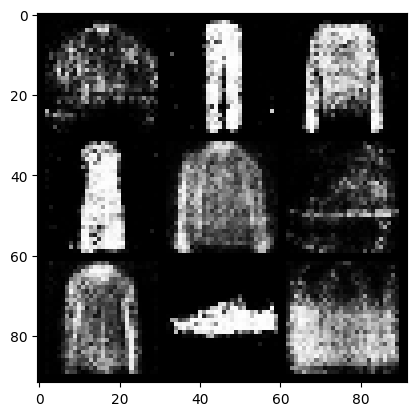

Starting epoch 23...
g_loss: 1.3557963371276855, d_loss: 1.1582300662994385


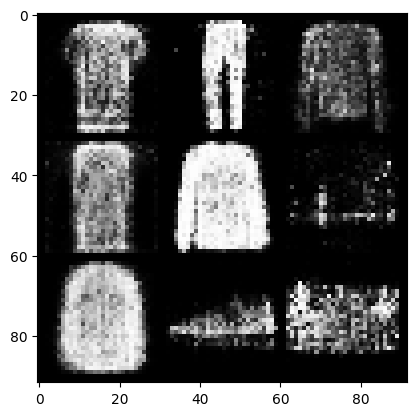

Starting epoch 24...
g_loss: 1.2088792324066162, d_loss: 0.9386961460113525


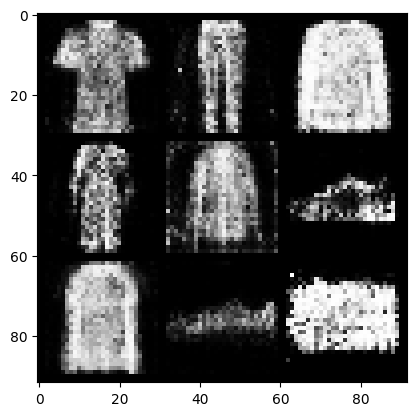

Starting epoch 25...
g_loss: 1.1679613590240479, d_loss: 1.0747147798538208


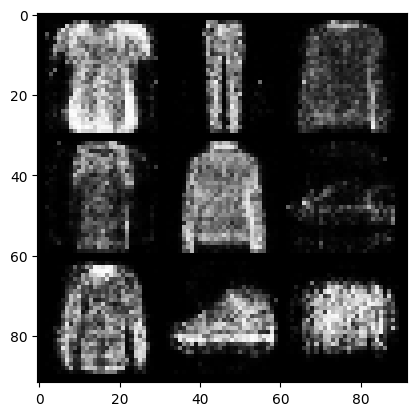

Starting epoch 26...
g_loss: 1.5150542259216309, d_loss: 1.1252037286758423


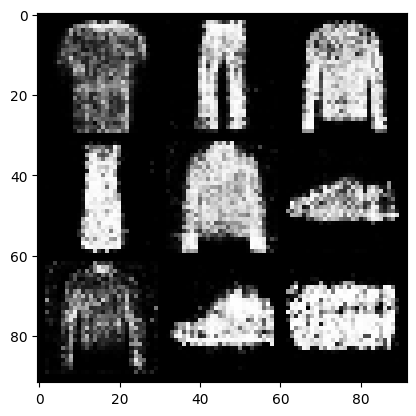

Starting epoch 27...
g_loss: 1.1220492124557495, d_loss: 1.345204472541809


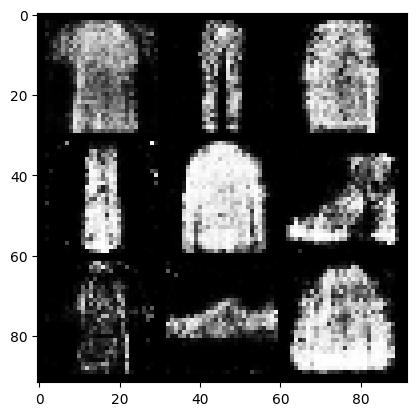

Starting epoch 28...
g_loss: 1.209199070930481, d_loss: 0.9323467016220093


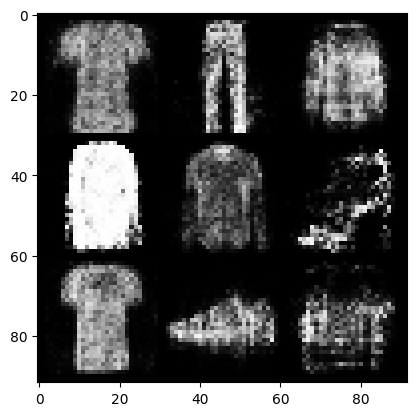

Starting epoch 29...
g_loss: 1.215773582458496, d_loss: 1.1375912427902222


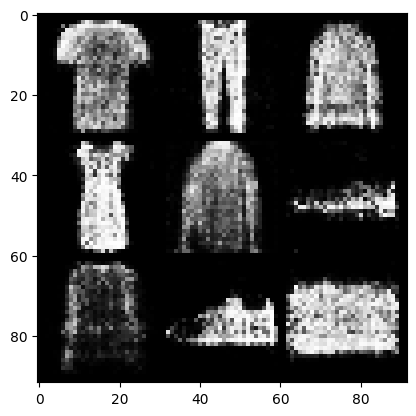

Starting epoch 30...
g_loss: 1.1476032733917236, d_loss: 0.947275698184967


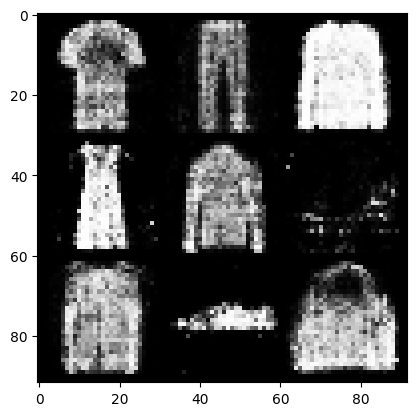

Starting epoch 31...
g_loss: 0.9828193187713623, d_loss: 1.0444886684417725


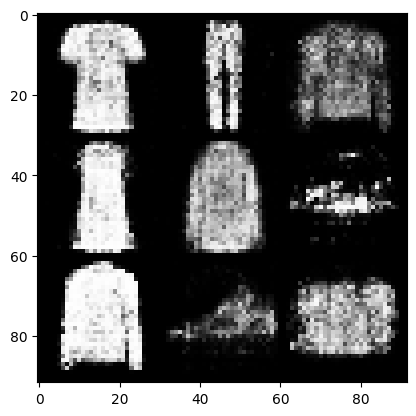

Starting epoch 32...
g_loss: 1.0860189199447632, d_loss: 1.0186829566955566


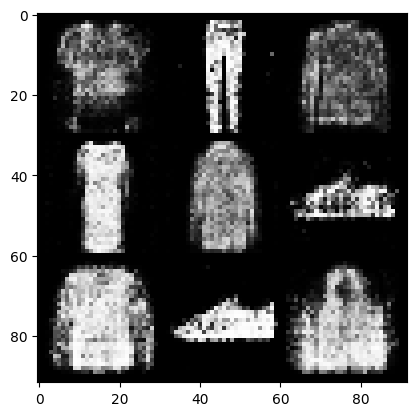

Starting epoch 33...
g_loss: 1.0626070499420166, d_loss: 1.1831355094909668


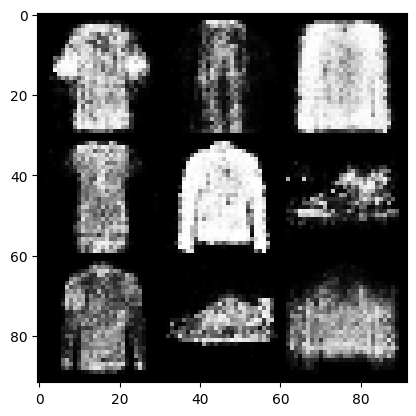

Starting epoch 34...
g_loss: 1.0258136987686157, d_loss: 1.0489561557769775


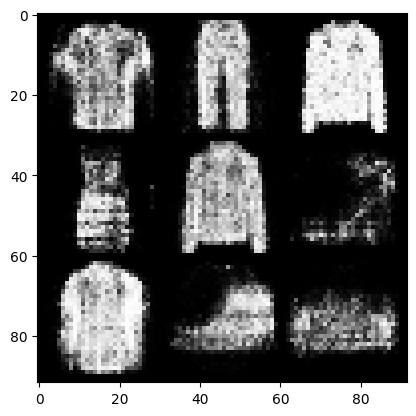

Starting epoch 35...
g_loss: 1.0418741703033447, d_loss: 1.1062028408050537


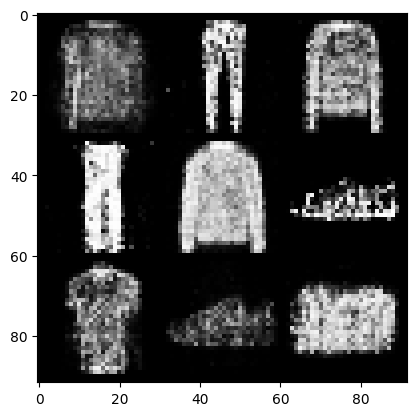

Starting epoch 36...
g_loss: 1.0200304985046387, d_loss: 1.4003247022628784


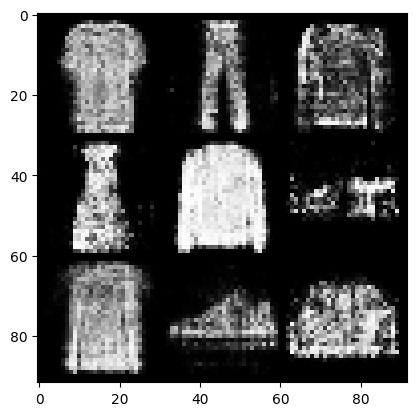

Starting epoch 37...
g_loss: 1.0220378637313843, d_loss: 1.0823999643325806


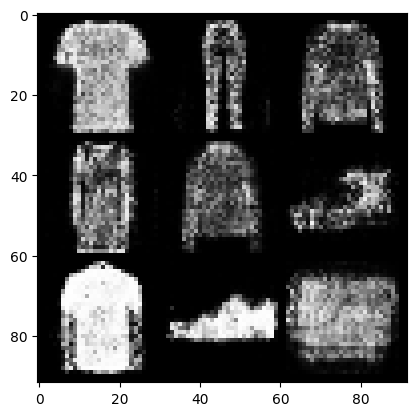

Starting epoch 38...
g_loss: 1.033512830734253, d_loss: 1.0066869258880615


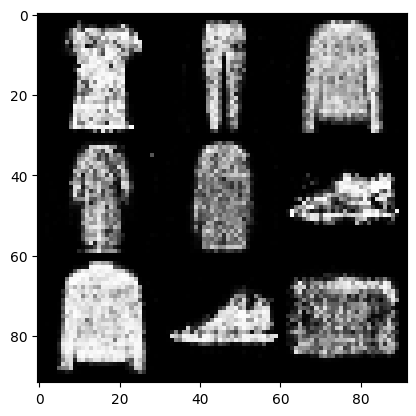

Starting epoch 39...
g_loss: 0.8569412231445312, d_loss: 1.2289025783538818


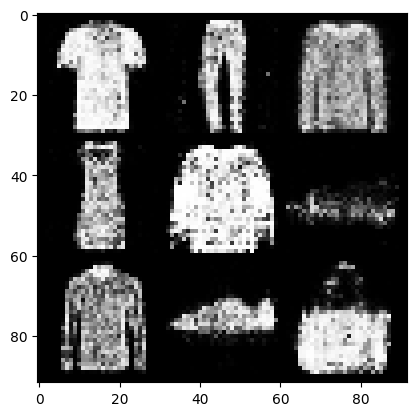

Starting epoch 40...
g_loss: 0.9495721459388733, d_loss: 1.1867645978927612


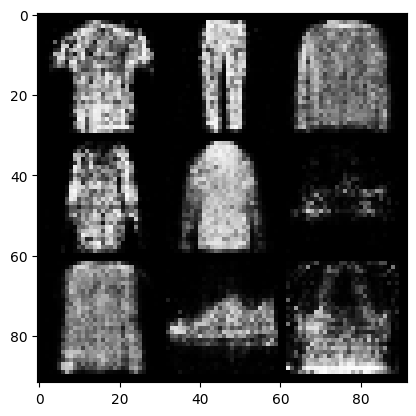

Starting epoch 41...
g_loss: 1.055302381515503, d_loss: 1.2378543615341187


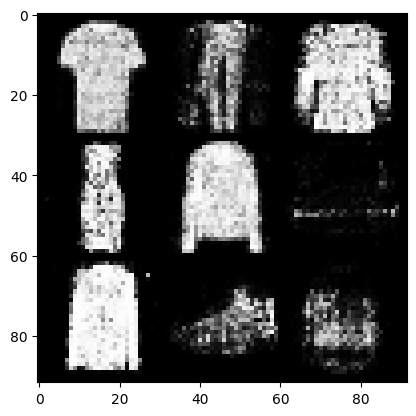

Starting epoch 42...
g_loss: 1.0346083641052246, d_loss: 1.2437191009521484


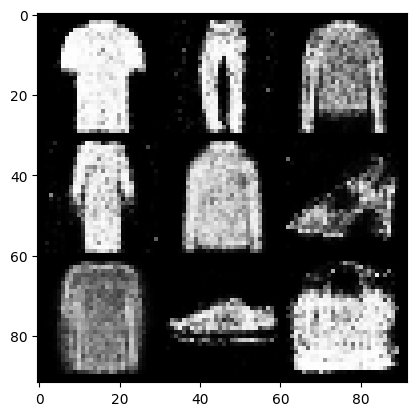

Starting epoch 43...
g_loss: 0.9177036285400391, d_loss: 1.1511645317077637


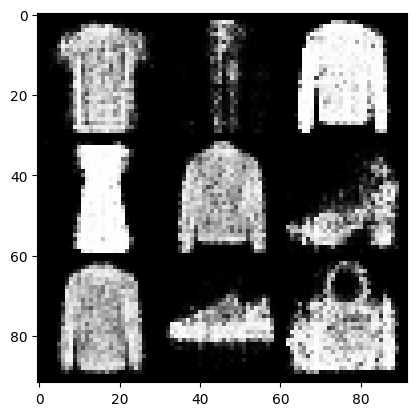

Starting epoch 44...
g_loss: 0.9983581900596619, d_loss: 1.2046105861663818


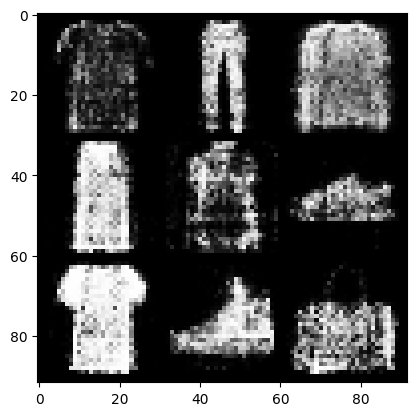

Starting epoch 45...
g_loss: 0.8455905914306641, d_loss: 1.1620206832885742


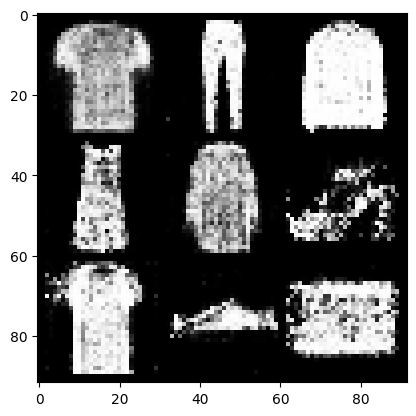

Starting epoch 46...
g_loss: 0.963360071182251, d_loss: 1.1695326566696167


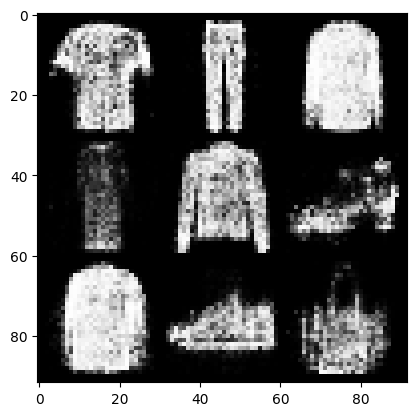

Starting epoch 47...
g_loss: 0.9529078602790833, d_loss: 1.225555419921875


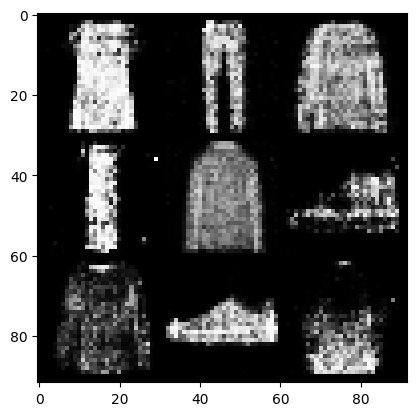

Starting epoch 48...
g_loss: 0.9368306994438171, d_loss: 1.2984355688095093


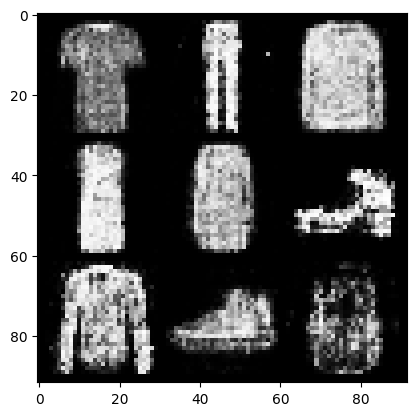

Starting epoch 49...
g_loss: 0.981931209564209, d_loss: 1.1496472358703613


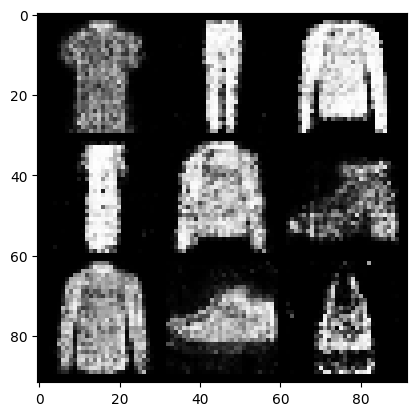

Starting epoch 50...
g_loss: 1.0885331630706787, d_loss: 1.1932522058486938


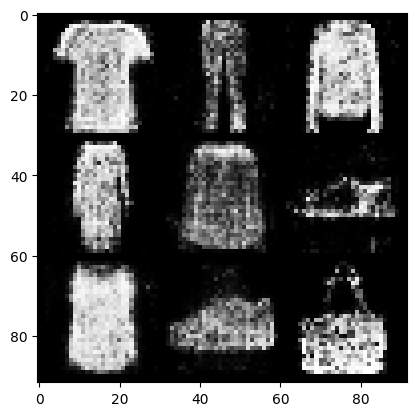

In [14]:
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np

for epoch in range(epochs):

    print('Starting epoch {}...'.format(epoch+1))

    for i, (images, labels) in enumerate(data_loader):

        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    # Set generator eval
    generator.eval()

    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    # Building z
    z = Variable(torch.randn(class_num-1, z_size)).to(device)

    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

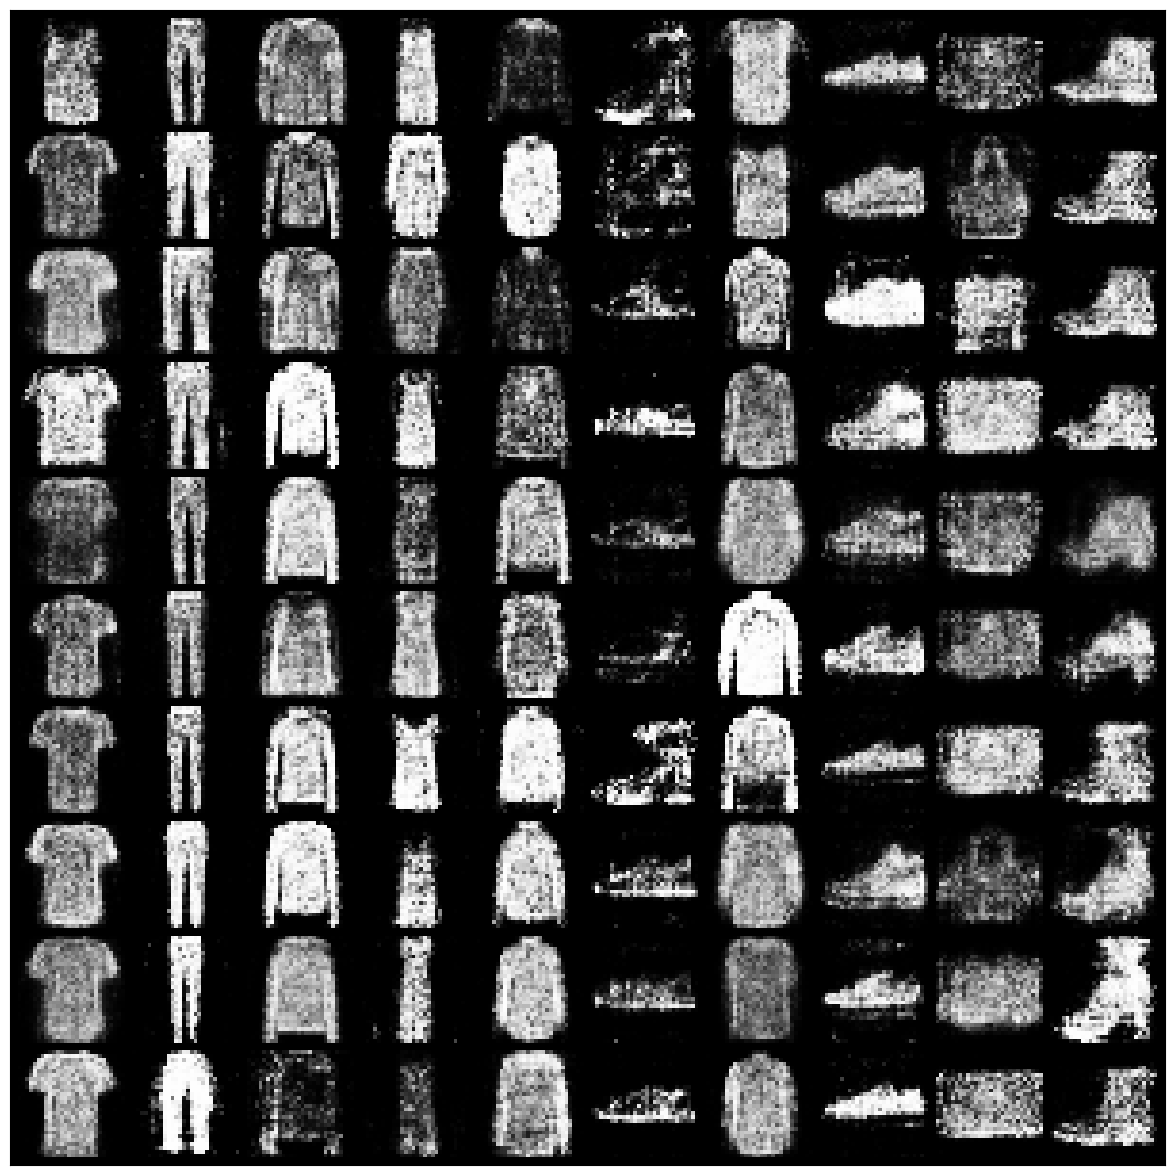

In [16]:
# Building z
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks([])
